<h1 ><big><center>Object recognition and computer vision 2022/2023</center></big></h1>

<h3><big><center><a href="http://www.di.ens.fr/~ponce/">Jean Ponce</a>, <a href="http://www.di.ens.fr/~laptev/">Ivan Laptev</a>, <a href="http://lear.inrialpes.fr/~schmid/">Cordelia Schmid</a> and <a href="http://www.di.ens.fr/~josef/">Josef Sivic</a></center></big></h3>


<h2><big><center> Assignment 3: Bird Classification Kaggle competition</center></big></h2>


</br>

<p align="center">
<img height=300px src="http://www.di.ens.fr/willow/teaching/recvis_orig/assignment3/images/fullyconn.png"/></p>
<p align="center">Figure 1</p>
<p align="center"></p>

**STUDENT**:  Ambroise ODONNAT

**EMAIL**:  ambroise.odonnat@eleves.enpc.fr

Inspired from [this notebook](https://github.com/antoyang/bird-classification/blob/master/Birds_Augmentation.ipynb)

## **Import**

In [ ]:
!pip install -U torch torchvision cython
!pip install -U 'git+https://github.com/facebookresearch/fvcore.git' 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |██████████████████████████████  | 834.1 MB 1.3 MB/s eta 0:00:45tcmalloc: large alloc 1147494400 bytes == 0x6625e000 @  0x7f4d46d9a615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |████████████████████████████████| 890.2 MB 6.8 kB/s 
     |████████████████████████████████| 24.3 MB 1.3 MB/s 
     |████████████████████████████████| 849 kB 55.5 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 317.1 MB 29 kB/s 
     |████████████████████████████████| 557.1 MB 11 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully unin

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/MVA/Courses/Object_Recognition_Computer_Vision/TPs/MVA_2022_RecVis_Kaggle") # folder containing the notebook and the data
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
A3_ODONNAT_Ambroise.ipynb     bird_dataset.zip	kaggle_v2.csv  recvis22_a3
Bird_data_augmentation.ipynb  kaggle_v0_69.csv	kaggle_v3.csv
bird_dataset		      kaggle_v1_71.csv	models


## The purpose of the function below is to crop images of bird.

In [ ]:
# Some basic setup
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import os
import sys

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
# Define a Mask-R-CNN model in Detectron2
cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Detection Threshold 
cfg.MODEL.ROI_HEADS.NMS = 0.4 # Non Maximum Suppression Threshold 
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"
model = DefaultPredictor(cfg)

model_final_f10217.pkl: 178MB [00:14, 12.1MB/s]                           


In [ ]:
%pwd

'/content'

In [ ]:
im = cv2.imread('bird_dataset/train_images/030.Fish_Crow/Fish_Crow_0072_25945.jpg')
outputs = model(im)

print(outputs["instances"].pred_classes)
print(outputs["instances"].scores)

tensor([14, 75], device='cuda:0')
tensor([0.9964, 0.8037], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


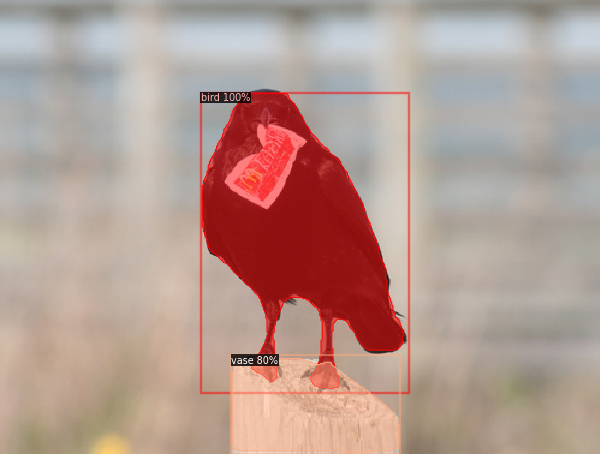

In [ ]:
# Example - Plot a bounding box
from detectron2.utils.visualizer import Visualizer
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
def detect_birds(model, input_folder, output_folder):
  for data_folder in list(os.listdir(input_folder)): # Iterate over train, val and test
    non_cropped = 0
    non_cropped_names = []
    num_imgs = 0
    directory = input_folder+'/'+data_folder
    print("\nDetecting birds on :", data_folder)
    for folder in list(os.listdir(directory)): # Iterate over classes of birds
      size = len(list(os.listdir(directory+'/'+folder)))
      num_imgs += size
      os.makedirs(output_folder, exist_ok = True)
      os.makedirs(output_folder+'/'+data_folder+'/'+folder, exist_ok = True)

      img_paths = []          
      img_detections = [] 

      # Reformat weird images
      for file in os.listdir(directory+'/'+folder):
        i = plt.imread(directory+'/'+folder+'/'+file)
        if len(i.shape)==2 or i.shape[2]!=3:
          i = Image.fromarray(i)
          i = i.convert('RGB')
          i.save(directory+'/'+folder+'/'+file)
      del i
                
      # Get image paths and detections : not the most efficient way, but it avoids defining a proper detectron2-specific Dataloader 
      for img_path in list(os.listdir(directory+'/'+folder)):
        img = cv2.imread(directory+'/'+folder+'/'+img_path)
        with torch.no_grad():
          detections = model(img)["instances"]
        img_paths.append(directory+'/'+folder+'/'+img_path)
        img_detections.append(detections)

      # Save cropped images
      for (path, detections) in (zip(img_paths, img_detections)):
        img = np.array(Image.open(path))

        # Bounding boxes and labels of detections
        if len(detections.scores)>0:

          # Get the most probable bird prediction bounding box
          index_birds = np.where(detections.pred_classes.cpu().numpy()==14)[0] # 14 is the default class number for bird
          if len(index_birds)==0:
            # Flip the image if we are not able to detect the bird
            non_cropped_names.append(path)
            non_cropped += 1
            path = path.split("/")[-1]
            plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+path, np.array(ImageOps.mirror(Image.fromarray(img))), dpi=1000)
            plt.close()  
            continue
          bird = int(torch.max(detections.scores[index_birds],0)[1].cpu().numpy())
          [x1,y1,x2,y2]=detections.pred_boxes[index_birds][bird].tensor[0].cpu().numpy()
          count=1

          # If we are able to detect the bird, enlarge the bounding box and generate a new image
          x1, y1 = np.maximum(0,int(x1)-20), np.maximum(0,int(y1)-20)
          x2, y2 = np.minimum(x2+40,img.shape[1]), np.minimum(y2+40,img.shape[0])
          img = img[int(np.ceil(y1)):int(y2), int(np.ceil(x1)):int(x2), :]

          # Save generated image with detections
          path = path.split("/")[-1]
          plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+path, img, dpi=1000)
          plt.close()   
          
        else:
          # Flip the image if we are not able to detect the bird
          non_cropped_names.append(path)
          non_cropped+=1
          path = path.split("/")[-1]
          # Flip the image if we are not able to detect it
          plt.imsave(output_folder+'/'+data_folder+'/'+folder+'/'+path, np.array(ImageOps.mirror(Image.fromarray(img))), dpi=1000)
          plt.close()  

    print("\t{}% of {} images non cropped".format(np.round(100*non_cropped/num_imgs,2),data_folder))
  return(non_cropped_names)

In [ ]:
input_folder = 'bird_dataset'
output_folder = 'bird_dataset_cropped'
detect_birds(model, input_folder, output_folder)


Detecting birds on : val_images
	2.91% of val_images images non cropped

Detecting birds on : train_images
	1.66% of train_images images non cropped

Detecting birds on : test_images
	3.48% of test_images images non cropped


['bird_dataset/test_images/mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg',
 'bird_dataset/test_images/mistery_category/c530c6986170aa1aefe7a930a56ad0db.jpg',
 'bird_dataset/test_images/mistery_category/bc27f534edd690cffdb07f3b314c44c3.jpg',
 'bird_dataset/test_images/mistery_category/0247efd7b9d47d036bb4390202a13e69.jpg',
 'bird_dataset/test_images/mistery_category/da9aa4eaae3ec62de9195ae742dcf2ad.jpg',
 'bird_dataset/test_images/mistery_category/1b62fffcbf47a4f9e32b400edc662f1f.jpg',
 'bird_dataset/test_images/mistery_category/09908286566fd3824e2db5d7fb2826b5.jpg',
 'bird_dataset/test_images/mistery_category/64f3fa85502e9cff91d6dc88f54be7cb.jpg',
 'bird_dataset/test_images/mistery_category/b5316c8e51b97debf6420b34325ec114.jpg',
 'bird_dataset/test_images/mistery_category/a52ab6ca2ec1dcd0e4834c50bb69cb3f.jpg',
 'bird_dataset/test_images/mistery_category/a05ed5dd6cbd3097e81e3c76ac690465.jpg',
 'bird_dataset/test_images/mistery_category/4dd33eb8e7500905866f3067e11535e4.jpg',
 'bi